In [5]:
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy as np
import pandas as pd
import sys
import time
from scipy.stats import entropy
from math import log, e
from scipy.stats.stats import pearsonr  

plt.rc('axes', titlesize=20) 
plt.rc('axes', labelsize=15)
plt.rc('legend', fontsize=20)

In [6]:
data_raw = pd.read_csv('AP221Harvardx.csv')

/Users/wfried/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (4,27,28,45,46,47,48,49,55,56,59,60,63) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [299]:
data_raw.head(5)

,course_id,user_id,registered,viewed,explored,certified,completed,ip,cc_by_ip,countryLabel,...,roles_isInstructor,roles_isStaff,roles_isCCX,roles_isFinance,roles_isLibrary,roles_isSales,forumRoles_isAdmin,forumRoles_isCommunityTA,forumRoles_isModerator,forumRoles_isStudent
0,HarvardX/PH525.1x/1T2018,814784,True,True,False,False,False,74.12.190.49,CA,Canada,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,HarvardX/PH525.1x/1T2018,7945078,True,False,NaN,False,False,60.10.17.72,CN,China,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,HarvardX/PH525.1x/1T2018,5465534,True,True,False,False,False,109.196.85.139,PL,Poland,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,HarvardX/PH525.1x/1T2018,8087152,True,True,False,False,False,203.110.242.10,IN,India,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,HarvardX/PH525.1x/1T2018,5032030,True,False,NaN,False,False,96.82.226.121,US,United States,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [300]:
data_raw.shape

(6860993, 91)

In [30]:
# specify QI and not QI fields
quasi_identifiers = 'course_id YoB countryLabel LoE gender nforum_posts'.split()
non_qi_fields = ['grade']
df = data_raw[quasi_identifiers + non_qi_fields]

In [43]:
df.shape

(6860993, 7)

In [44]:
df.head()

,course_id,YoB,countryLabel,LoE,gender,nforum_posts,grade
0,HarvardX/PH525.1x/1T2018,NaN,Canada,NaN,NaN,NaN,NaN
1,HarvardX/PH525.1x/1T2018,NaN,China,NaN,NaN,NaN,NaN
2,HarvardX/PH525.1x/1T2018,NaN,Poland,NaN,NaN,NaN,NaN
3,HarvardX/PH525.1x/1T2018,NaN,India,NaN,NaN,NaN,NaN
4,HarvardX/PH525.1x/1T2018,NaN,United States,NaN,NaN,NaN,NaN


In [8]:
filename = 'partial_dataset.csv'

In [46]:
df.to_csv(filename, index=False)

In [9]:
df_original = pd.read_csv(filename)

In [10]:
df_original.head()

,course_id,YoB,countryLabel,LoE,gender,nforum_posts,grade
0,HarvardX/PH525.1x/1T2018,NaN,Canada,NaN,NaN,NaN,NaN
1,HarvardX/PH525.1x/1T2018,NaN,China,NaN,NaN,NaN,NaN
2,HarvardX/PH525.1x/1T2018,NaN,Poland,NaN,NaN,NaN,NaN
3,HarvardX/PH525.1x/1T2018,NaN,India,NaN,NaN,NaN,NaN
4,HarvardX/PH525.1x/1T2018,NaN,United States,NaN,NaN,NaN,NaN


In [11]:
df_original.isna().sum()

course_id             0
YoB             1049890
countryLabel    1109868
LoE              998390
gender           914661
nforum_posts    6623522
grade           1930278
dtype: int64

In [12]:
# minimum non-null grade value
nforum_posts_not_null = [x for x in df_original.nforum_posts if not pd.isnull(x)]
min(nforum_posts_not_null)

1.0

In [13]:
# convert null nforum_post values to 0 
df_original.nforum_posts = [0 if pd.isnull(x) else x for x in df_original.nforum_posts]

In [15]:
# correlation between gread and nforum_posts in original dataset
df_original_grade_not_null = df_original[~pd.isnull(df_original.grade)]
original_corr = pearsonr(df_original_grade_not_null.grade, df_original_grade_not_null.nforum_posts)[0]

In [16]:
# highest number of nforum_posts in dataset
nforum_posts_not_null_sorted = sorted(nforum_posts_not_null)
nforum_posts_not_null_sorted[-10:]

[808.0, 823.0, 842.0, 903.0, 982.0, 1091.0, 1149.0, 1223.0, 1504.0, 3770.0]

In [17]:
df_original[pd.isnull(df_original.grade)].nforum_posts.value_counts(dropna=False)[:10]

0.0     1902903
1.0       15916
2.0        3801
3.0        1986
4.0        1332
5.0         783
6.0         558
7.0         385
8.0         321
9.0         271
10.0        191
Name: nforum_posts, dtype: int64

In [18]:
grades_original_not_null = [x for x in df_original.grade if not pd.isnull(x)]

In [20]:
grades_original_not_zero = [x for x in grades_original_not_null if x > 0]

In [21]:
len(grades_original_not_zero) / len(df_original)

0.08187371711354319

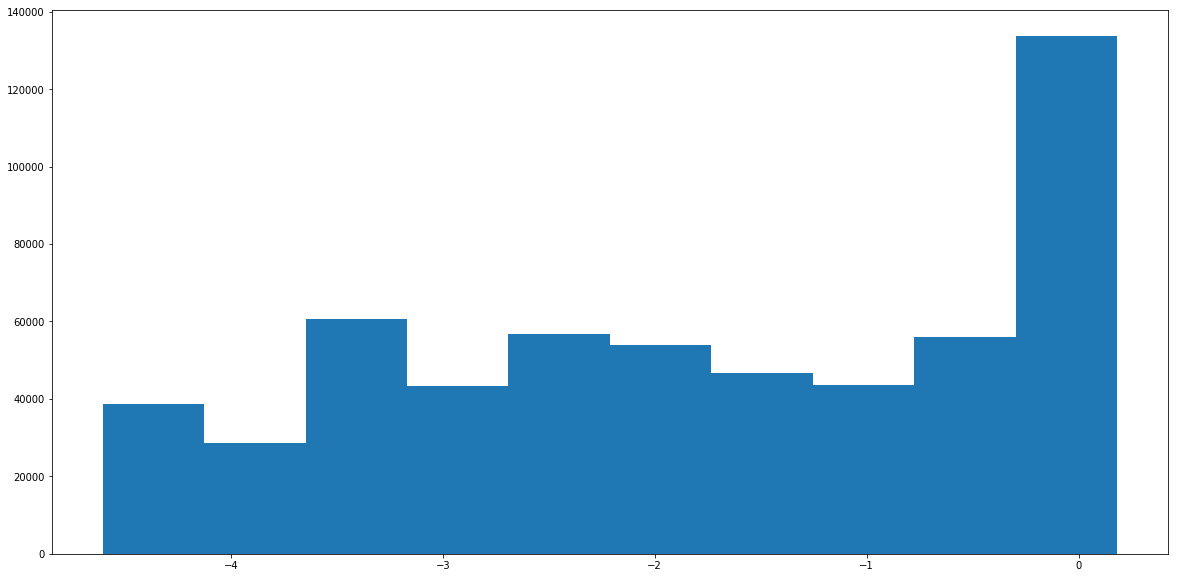

In [22]:
plt.figure(figsize=(20, 10))
plt.hist(np.log(np.array(grades_original_not_zero)))
plt.show()

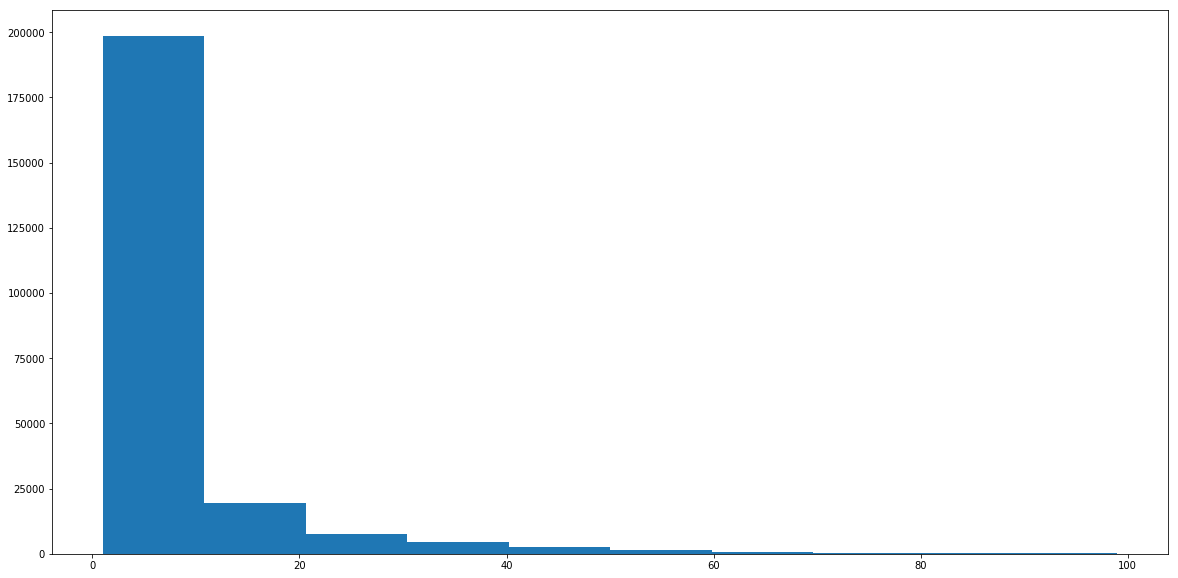

In [23]:
f = [x for x in df_original.nforum_posts if 0 < x < 100]
plt.figure(figsize=(20, 10))
plt.hist(f)
plt.show()

In [53]:
mean_grade_original = np.mean(grades_original_not_null)
mean_grade_original

0.04063550620954564

In [27]:
grades_fraction_null = 1 - (len(grades_original_not_null) / len(df_original))
grades_fraction_null

0.28134090794145983

In [28]:
#fill NaN with string null to make groupby capture all possible combinations
df_naive = df_original.copy(deep=True)
df_naive = df_naive.fillna('Null')
df_naive.head()

,course_id,YoB,countryLabel,LoE,gender,nforum_posts,grade
0,HarvardX/PH525.1x/1T2018,Null,Canada,Null,Null,0.0,Null
1,HarvardX/PH525.1x/1T2018,Null,China,Null,Null,0.0,Null
2,HarvardX/PH525.1x/1T2018,Null,Poland,Null,Null,0.0,Null
3,HarvardX/PH525.1x/1T2018,Null,India,Null,Null,0.0,Null
4,HarvardX/PH525.1x/1T2018,Null,United States,Null,Null,0.0,Null


In [31]:
# get count of each unique set of QIs
counts_df = df_naive.groupby(quasi_identifiers, as_index=False).size().reset_index(name='counts')

In [32]:
counts_df.head()

,course_id,YoB,countryLabel,LoE,gender,nforum_posts,counts
0,HarvardX/1368.1x/2T2016,1901,Null,hs,m,0.0,1
1,HarvardX/1368.1x/2T2016,1915,Netherlands,m,m,0.0,1
2,HarvardX/1368.1x/2T2016,1925,United States,b,f,0.0,1
3,HarvardX/1368.1x/2T2016,1933,United States,m,m,0.0,1
4,HarvardX/1368.1x/2T2016,1935,United States,b,f,0.0,1


In [33]:
# calculate number of times each set of QIs need to be duplicated in synthetic datset
k = 5
qi_copy_lst = []
for index, row in counts_df.iterrows():
    count = row['counts']
    if count < k:
        new_rows = k - count
        qi_copy_lst.extend([list(row.values)[:-1]] * new_rows)

In [36]:
# independently draw each column value as the mean of 5 random choices
def random_mean(n_samples, n_choices=5, fill_in=True):
    if fill_in:
        choices = np.random.choice(grades_original_not_null, size=(n_samples, n_choices), replace=True)
        return np.mean(choices, axis=1)
    return [9999] * n_samples

In [37]:
mean_choices = random_mean(len(qi_copy_lst))

In [38]:
grade_no_fill_naive = random_mean(len(qi_copy_lst), fill_in=False)

In [39]:
df_synthetic_naive = pd.DataFrame(qi_copy_lst, columns=quasi_identifiers)
df_synthetic_naive.head()

,course_id,YoB,countryLabel,LoE,gender,nforum_posts
0,HarvardX/1368.1x/2T2016,1901,Null,hs,m,0.0
1,HarvardX/1368.1x/2T2016,1901,Null,hs,m,0.0
2,HarvardX/1368.1x/2T2016,1901,Null,hs,m,0.0
3,HarvardX/1368.1x/2T2016,1901,Null,hs,m,0.0
4,HarvardX/1368.1x/2T2016,1915,Netherlands,m,m,0.0


In [40]:
df_synthetic_naive['grade'] = mean_choices
df_synthetic_naive['grade'] = df_synthetic_naive['grade'].sample(frac=1 - grades_fraction_null)
df_synthetic_naive.replace('Null', np.nan, inplace=True)
df_synthetic_naive.head()

,course_id,YoB,countryLabel,LoE,gender,nforum_posts,grade
0,HarvardX/1368.1x/2T2016,1901.0,NaN,hs,m,0.0,NaN
1,HarvardX/1368.1x/2T2016,1901.0,NaN,hs,m,0.0,0.010
2,HarvardX/1368.1x/2T2016,1901.0,NaN,hs,m,0.0,0.000
3,HarvardX/1368.1x/2T2016,1901.0,NaN,hs,m,0.0,0.072
4,HarvardX/1368.1x/2T2016,1915.0,Netherlands,m,m,0.0,0.180


In [41]:
df_synthetic_naive_no_fill = df_synthetic_naive.copy()
df_synthetic_naive_no_fill['grade'] = grade_no_fill_naive
df_synthetic_naive_no_fill.replace('Null', np.nan, inplace=True)
df_synthetic_naive_no_fill.head()

,course_id,YoB,countryLabel,LoE,gender,nforum_posts,grade
0,HarvardX/1368.1x/2T2016,1901.0,NaN,hs,m,0.0,9999
1,HarvardX/1368.1x/2T2016,1901.0,NaN,hs,m,0.0,9999
2,HarvardX/1368.1x/2T2016,1901.0,NaN,hs,m,0.0,9999
3,HarvardX/1368.1x/2T2016,1901.0,NaN,hs,m,0.0,9999
4,HarvardX/1368.1x/2T2016,1915.0,Netherlands,m,m,0.0,9999


In [42]:
df_final_naive_no_fill = pd.concat([df_original, df_synthetic_naive_no_fill])
df_final_naive_no_fill.tail()

,course_id,YoB,countryLabel,LoE,gender,nforum_posts,grade
6078948,VJx/VJx_S/3T2015,NaN,United States,p_se,m,0.0,9999.0
6078949,VJx/VJx_S/3T2015,NaN,Uruguay,NaN,NaN,0.0,9999.0
6078950,VJx/VJx_S/3T2015,NaN,Uruguay,NaN,NaN,0.0,9999.0
6078951,VJx/VJx_S/3T2015,NaN,Uruguay,NaN,NaN,0.0,9999.0
6078952,VJx/VJx_S/3T2015,NaN,Uruguay,NaN,NaN,0.0,9999.0


In [44]:
df_final_naive_no_fill.to_csv('synthetic_dataset_naive.csv')

In [45]:
df_final_naive = pd.concat([df_original, df_synthetic_naive])
df_final_naive.head()

,course_id,YoB,countryLabel,LoE,gender,nforum_posts,grade
0,HarvardX/PH525.1x/1T2018,NaN,Canada,NaN,NaN,0.0,NaN
1,HarvardX/PH525.1x/1T2018,NaN,China,NaN,NaN,0.0,NaN
2,HarvardX/PH525.1x/1T2018,NaN,Poland,NaN,NaN,0.0,NaN
3,HarvardX/PH525.1x/1T2018,NaN,India,NaN,NaN,0.0,NaN
4,HarvardX/PH525.1x/1T2018,NaN,United States,NaN,NaN,0.0,NaN


In [46]:
counts_df_check = df_final_naive.groupby(quasi_identifiers, as_index=False).size().reset_index(name='counts')
counts_df_check.head(50)

,course_id,YoB,countryLabel,LoE,gender,nforum_posts,counts
0,HarvardX/1368.1x/2T2016,1915.0,Netherlands,m,m,0.0,5
1,HarvardX/1368.1x/2T2016,1925.0,United States,b,f,0.0,5
2,HarvardX/1368.1x/2T2016,1933.0,United States,m,m,0.0,5
3,HarvardX/1368.1x/2T2016,1935.0,United States,b,f,0.0,5
4,HarvardX/1368.1x/2T2016,1936.0,United States,a,m,0.0,5
5,HarvardX/1368.1x/2T2016,1937.0,United States,m,f,0.0,5
6,HarvardX/1368.1x/2T2016,1938.0,United States,p,m,0.0,5
7,HarvardX/1368.1x/2T2016,1939.0,United States,m,m,0.0,5
8,HarvardX/1368.1x/2T2016,1940.0,United States,b,f,0.0,5
9,HarvardX/1368.1x/2T2016,1940.0,United States,m,f,4.0,5


In [50]:
grades_not_null_naive = [x for x in df_final_naive.grade if not pd.isnull(x)]
mean_grade_naive = np.mean(grades_not_null_naive)

In [51]:
mean_grade_naive

0.04061560077467283

In [56]:
print("mean bias of Waldo's method:", mean_grade_naive - mean_grade_original)

mean bias of Waldo's method: -1.990543487281199e-05


In [88]:
df_final_naive_grade_not_null = df_final_naive[~pd.isnull(df_final_naive.grade)]
naive_corr = pearsonr(df_final_naive_grade_not_null.grade, df_final_naive_grade_not_null.nforum_posts)[0]

In [60]:
print("correlation bias of Waldo's method:", original_corr - naive_corr)

correlation bias of Waldo's method: 0.14471684235495175


In [61]:
qi_df_original = df_original.drop(columns=['grade'])

In [62]:
def apply_to_chunk(df_small):
    '''Map unique combinations of non-null quasi identifiers to the corresponding row numbers.'''
    qi_combo2rows = defaultdict(list)
    for idx, row in df_small.iterrows():
        s = ''
        for col_name in quasi_identifiers:
            if not pd.isnull(row[col_name]):
                s += f'{col_name}={row[col_name]}|'
        s = s[:-1]
        qi_combo2rows[s].append(idx)
    
    return qi_combo2rows

# use parallel processing to speed up calculations
df_split = np.array_split(qi_df_original, mp.cpu_count())
p = mp.Pool()
return_vals = p.map(apply_to_chunk, df_split)

# combine results of different processes 
qi_combo2rows = defaultdict(list)
for dic in return_vals:
    for k, v in dic.items():
        qi_combo2rows[k].extend(v)

# map string representation of combination of non-null quasi identifiers to set of non-null quasi identifiers
qi_combos = list(qi_combo2rows.keys())
qi_combo2set = {qi_combo: set(qi_combo.split('|')) for qi_combo in qi_combos}

In [63]:
# build nested dictionary where key of outer dictionary is value of course_id and key of inner dictionary is 
# value of YoB for those rows that have non-null YoB. Meanwhile, the value of the inner dictionary is a list 
# of records with the corresponding course_id and YoB that are not subsets of each other. The purpose of 
# the dictionary structure is to speed up the computation of determining which records are subsets/supersets of 
# other records by a factor of over 100.
missing_yob = set()
course_id2qi_combos = {}
for qi_combo in qi_combos:
    qi_vals = qi_combo.split('|')
    yob = qi_vals[1]
    if not yob.startswith(quasi_identifiers[1]):
        missing_yob.add(qi_combo)
    else:
        course_id = qi_vals[0]
        if course_id not in course_id2qi_combos:
            course_id2qi_combos[course_id] = {yob: {qi_combo}}
        else:
            inner_dict = course_id2qi_combos[course_id]
            if yob not in inner_dict:
                inner_dict[yob] = {qi_combo}
            else:
                qi_vals_set = set(qi_vals)
                candidates = inner_dict[yob]
                add_flag = True
                for candidate in candidates.copy():
                    candidate_set = qi_combo2set[candidate]
                    if candidate_set.issuperset(qi_vals_set):
                        add_flag = False
                        break
                    if qi_vals_set.issuperset(candidate_set):
                        candidates.remove(candidate)
                if add_flag:
                    candidates.add(qi_combo) 

In [64]:
# flatten inner dictionary above such that there is a single dictionary that maps course_id to combination of 
# non-null quasi identifiers that are not subsets of each other
agglomerated_dict = {}
for course_id, inner_dict in course_id2qi_combos.items():
    joining_set = set()
    for set_ in inner_dict.values():
        joining_set |= set_
    agglomerated_dict[course_id] = joining_set

In [65]:
# split up dictionary above into smaller dictionaries so that they could be processed in parallel
n_cores = mp.cpu_count()
len_array = np.array([len(values) for values in agglomerated_dict.values()])
frac_array = len_array / np.sum(len_array)
cumsum_array = np.cumsum(frac_array)

dic_lst = []
pnt = 0
core_pnt = 1
curr_dic = {}
for course_id, qi_combos in agglomerated_dict.items():
    curr_dic[course_id] = qi_combos
    if cumsum_array[pnt] > (core_pnt / n_cores) - 0.0001:
        dic_lst.append(curr_dic)
        curr_dic = {}
        core_pnt += 1 
    pnt += 1     

In [66]:
# assign each record with null value for YoB to appropriate core number in preparation for parallel processing
list_of_sets = [set() for i in range(n_cores)]
for qi_combo in missing_yob:
    was_added = False
    course_id = qi_combo.split('|')[0]
    for i, dic in enumerate(dic_lst):
        if course_id in dic:
            list_of_sets[i].add(qi_combo)
            was_added = True
            break
    
    if not was_added:
        raise RuntimeError("qi_combo wasn't added")

zipped_lst = list(zip(dic_lst, list_of_sets))

In [67]:
# add records with null YoB values to the dictionaries that map course_id to combinations of non-null quasi 
# identifiers that are not subsets of each other
def handle_null_vals(tup):
    partial_dict, missing_yob = tup
    for qi_combo in missing_yob:
        qi_vals = qi_combo.split('|')
        course_id = qi_vals[0]
        if course_id not in partial_dict:
            partial_dict[course_id] = {qi_combo}
        else:
            qi_vals_set = set(qi_vals)
            candidates = partial_dict[course_id]
            add_flag = True
            for candidate in candidates.copy():
                candidate_set = qi_combo2set[candidate]
                if candidate_set.issuperset(qi_vals_set):
                    add_flag = False
                    break
            if add_flag:
                candidates.add(qi_combo)
    
    return partial_dict

In [68]:
p = mp.Pool()
complete_dicts = p.map(handle_null_vals, zipped_lst)

In [69]:
# combine values of dictionary into one large set
qis_to_augment = set()
for complete_dict in complete_dicts:
    for values in complete_dict.values():
        qis_to_augment |= values

In [269]:
# ensure that none of the records are subsets or supersets of any of the other records in the list
def check_supersets(set_, num=50):
    all_fields_lst = list(set_)
    for i, qi_combo in enumerate(all_fields_lst[:num]):
        for j in range(i+1, len(all_fields_lst)):
            qi_vals_set = qi_combo2set[qi_combo]
            candidate_set = qi_combo2set[all_fields_lst[j]]
            if candidate_set.issuperset(qi_vals_set):
                raise Exception('subset')
            elif qi_vals_set.issuperset(candidate_set):
                raise Exception('superset')

check_supersets(qis_to_augment)

In [71]:
# add the minimum number of synthetic records to achieve k-anonymity
def add_synethic_records(k=5):
    augmented_df = qi_df_original.copy()
    synethic_dict = defaultdict(list)
    for qi in qis_to_augment:
        rows = qi_combo2rows[qi]
        rows_to_add = k - len(rows)
        if rows_to_add > 0:
            row_to_add = rows[0]
            row_vals = augmented_df.iloc[row_to_add]
            for qi in quasi_identifiers:
                synethic_dict[qi].extend([row_vals[qi]] * rows_to_add)
    
    grade_vals = random_mean(len(synethic_dict[quasi_identifiers[0]]))
    synethic_dict['grade'] = grade_vals
    
    return pd.DataFrame.from_dict(synethic_dict)

In [72]:
df_synethic_not_naive = add_synethic_records()

In [78]:
df_synethic_not_naive.shape

(5319235, 7)

In [74]:
df_synethic_not_naive['grade'] = df_synethic_not_naive['grade'].sample(frac=1 - grades_fraction_null)

In [75]:
df_synethic_not_naive_no_fill = df_synethic_not_naive.copy()
df_synethic_not_naive_no_fill['grade'] = random_mean(len(df_synethic_not_naive), fill_in=False)

In [76]:
df_final_not_naive_no_fill = pd.concat([df_original, df_synethic_not_naive_no_fill])
df_final_not_naive_no_fill.tail()

,course_id,YoB,countryLabel,LoE,gender,nforum_posts,grade
5319230,HarvardX/GSE1x/2014_JFMA,1982.0,United States,b,f,1.0,9999.0
5319231,HarvardX/HDS3221.2x/1T2016,1983.0,Belgium,b,m,0.0,9999.0
5319232,HarvardX/HDS3221.2x/1T2016,1983.0,Belgium,b,m,0.0,9999.0
5319233,HarvardX/HDS3221.2x/1T2016,1983.0,Belgium,b,m,0.0,9999.0
5319234,HarvardX/SW12.6x/2T2014,1985.0,Taiwan,m,m,0.0,9999.0


In [371]:
df_final_not_naive_no_fill.to_csv('synthetic_dataset_supersets.csv')

In [80]:
df_final_not_naive = pd.concat([df_original, df_synethic_not_naive])

In [81]:
grades_not_null_not_naive = [x for x in df_final_not_naive.grade if not pd.isnull(x)]
mean_grade_not_naive = np.mean(grades_not_null_not_naive)

In [85]:
print("mean bias of Waldo's method with superset method:", mean_grade_not_naive - mean_grade_original)

mean bias of Waldo's method with superset method: 1.358685475191801e-05


In [86]:
df_final_not_naive_grade_not_null = df_final_not_naive[~pd.isnull(df_final_not_naive.grade)]
naive_corr = pearsonr(df_final_not_naive_grade_not_null.grade, df_final_not_naive_grade_not_null.nforum_posts)[0]

In [87]:
print("correlation bias of Waldo's method with superset method:", original_corr - naive_corr)

correlation bias of Waldo's method with superset method: 0.13681119789232088
